In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.autonotebook import tqdm

from sklearn.model_selection import train_test_split

from glob import glob
import torch
import torch.nn as nn
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
import torchvision

seed = 42

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Currently using "{device}" device.')


Currently using "cpu" device.


In [3]:
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

batch_size = 4
image_size = 256
num_classes = 1
epochs = 30
path = r'seg_model.pth'

In [5]:
path_images = r'./train_img/'
path_masks = r'./train_lab/'

images_paths = glob(path_images + '*.jpg')
masks_paths = glob(path_masks + '*.png')

images_paths = sorted([str(p) for p in images_paths])
masks_paths = sorted([str(p) for p in masks_paths])

df = pd.DataFrame({'images': images_paths, 'masks': masks_paths})

df.sample(2)

,images,masks
203,./train_img/7Q3A9064-12.jpg,./train_lab/7Q3A9064-12.png
266,./train_img/IMG27-5.jpg,./train_lab/IMG27-5.png


In [6]:
train, test = train_test_split(df, test_size=200, shuffle=True, random_state=seed)
train, valid = train_test_split(train, test_size=0.15, shuffle=True, random_state=seed)

print(f'Train size: {len(train)}, validation size: {len(valid)} and test size: {len(test)}')

Train size: 85, validation size: 15 and test size: 200


In [7]:
train_transforms = T.Compose([
    T.ToPILImage(),
    T.Resize((image_size, image_size)),
    # add some color augmentations manually if needed
    T.ToTensor()
])

In [8]:
class CrackDataset(Dataset):
    def __init__(self, dataset, transforms=train_transforms):
        self.dataset = dataset.reset_index(drop=True)
        self.transforms = transforms
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, ix):
        row = self.dataset.loc[ix].squeeze()
        image_path = row['images']
        mask_path = row['masks']
        
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_tensor = self.transforms(image).float()
        
        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = cv2.resize(mask, (image_size, image_size))
        _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        
        mask_tensor = torch.as_tensor(mask[None], dtype=torch.float32)
        
        # mask_tensor /= 255.
        
        return image_tensor, mask_tensor
    
    def collate_fn(self, batch):
        images, masks = tuple(zip(*batch))
        images = [img[None] for img in images]
        masks = [msk[None] for msk in masks]
        images, masks = [torch.cat(i).to(device) for i in [images, masks]]
        return images, masks

In [9]:
@torch.no_grad()
def validate_test_image(model, dataset):
    idx = np.random.randint(len(dataset))
    dataset = dataset.reset_index(drop=True)
    row = dataset.loc[idx].squeeze()
    
    image = cv2.imread(row['images'])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_tensor = train_transforms(image).unsqueeze(0).to(device)
    
    mask = cv2.imread(row['masks'])
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = cv2.resize(mask, (image_size, image_size))
    _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    
    model.eval()
    output = model(image_tensor)
    output = output['out'][0].cpu().detach().numpy().transpose(1,2,0)
    
    plt.figure(figsize=(8, 4))
    plt.subplot(131)
    plt.title('Original image')
    plt.imshow(image)
    
    plt.subplot(132)
    plt.title('Original mask')
    plt.imshow(mask, cmap='gray')
    
    plt.subplot(133)
    plt.title('Predicted mask')
    plt.imshow(output, cmap='gray')
    
    plt.tight_layout()
    plt.show()
    plt.pause(0.001)

In [10]:
train_dataset = CrackDataset(train)
valid_dataset = CrackDataset(valid)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=train_dataset.collate_fn, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=valid_dataset.collate_fn, drop_last=True)

In [11]:
from torchvision.models.segmentation.deeplabv3 import DeepLabHead

def get_model(output_channels=1, unfreeze=True):
    model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True, progress=False)
    
    for param in model.parameters():
        param.requires_grad = unfreeze
    
    model.classifier = DeepLabHead(2048, output_channels)
    
    return model.to(device)

model = get_model()  # set output_channels = 3 if we work with colored masks

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /Users/hjaviersarmientoy/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


In [12]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, path=path):
        self.path = path
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False
        
    def __call__(self, val_loss, model=None):
        if self.best_loss - val_loss > self.min_delta:
            torch.save(model.state_dict(), self.path)
            print(f'Model saved to: {self.path}')
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [13]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # if unfreeze=True -> 1e-4, 1e-5, so not to ruin good init w
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, min_lr=1e-6, factor=0.1)
early = EarlyStopping()

In [14]:
def train_one_batch(batch, model, criterion, optimizer):
    images, masks = batch
    optimizer.zero_grad()
    output = model(images)
    loss = criterion(output['out'], masks)
    loss.backward()
    optimizer.step()
    
    return loss.item()

@torch.no_grad()
def validate_one_batch(batch, model, criterion):
    images, masks = batch
    output = model(images)
    loss = criterion(output['out'], masks)
    return loss.item()

Epoch 1/30


Train loss: 1926.8245.


Valid loss: 1850.7433.
--------------------------------------------------


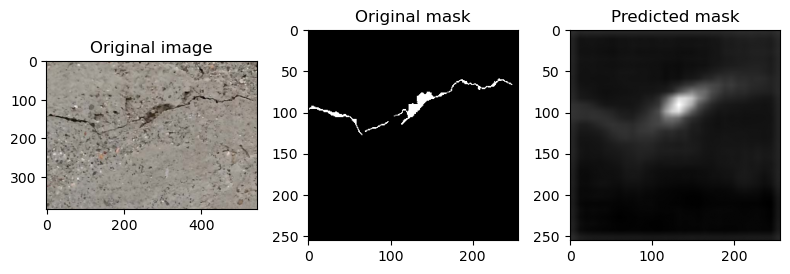

Model saved to: seg_model.pth
Epoch 2/30


Train loss: 1823.9410.


Valid loss: 1784.6438.
--------------------------------------------------


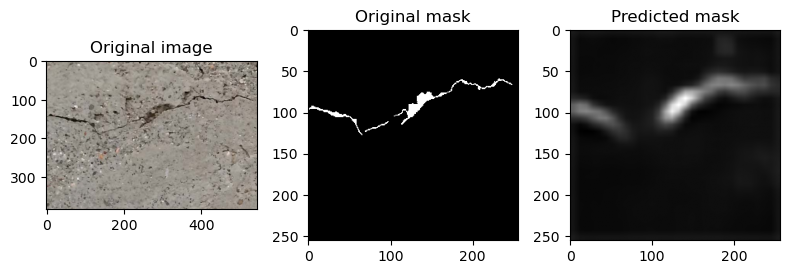

Model saved to: seg_model.pth
Epoch 3/30


Train loss: 1783.9950.


Valid loss: 1729.8303.
--------------------------------------------------


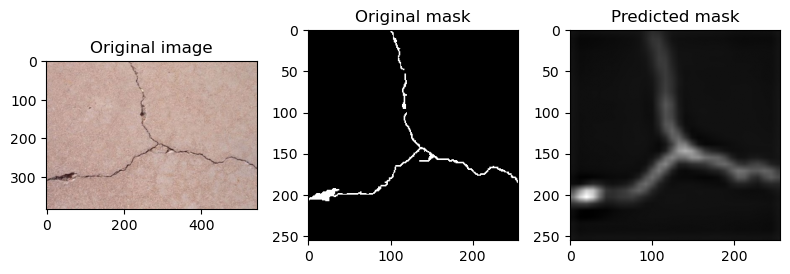

Model saved to: seg_model.pth
Epoch 4/30


Train loss: 1758.2351.


Valid loss: 1706.0634.
--------------------------------------------------


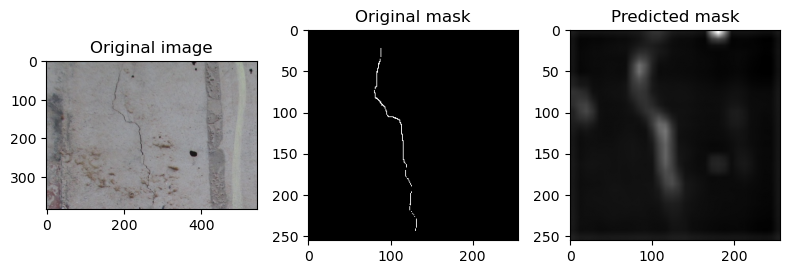

Model saved to: seg_model.pth
Epoch 5/30


Train loss: 1735.3332.


Valid loss: 1646.5841.
--------------------------------------------------


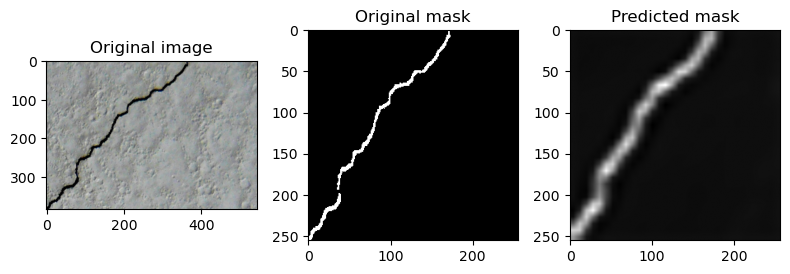

Model saved to: seg_model.pth
Epoch 6/30


Train loss: 1705.1662.


Valid loss: 1632.4991.
--------------------------------------------------


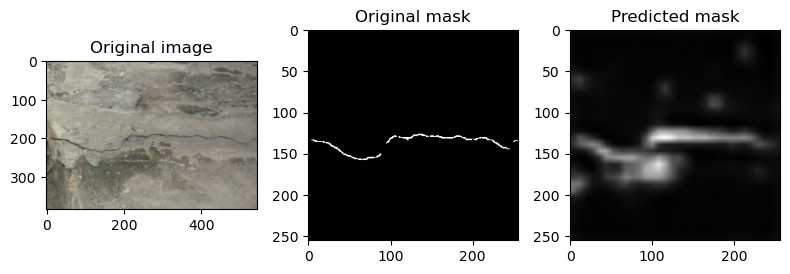

Model saved to: seg_model.pth
Epoch 7/30


Train loss: 1711.3090.


Valid loss: 1659.1056.
--------------------------------------------------


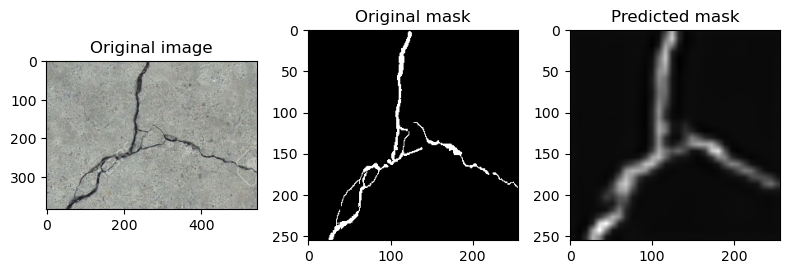

INFO: Early stopping counter 1 of 5
Epoch 8/30


Train loss: 1691.3735.


Valid loss: 1643.6862.
--------------------------------------------------


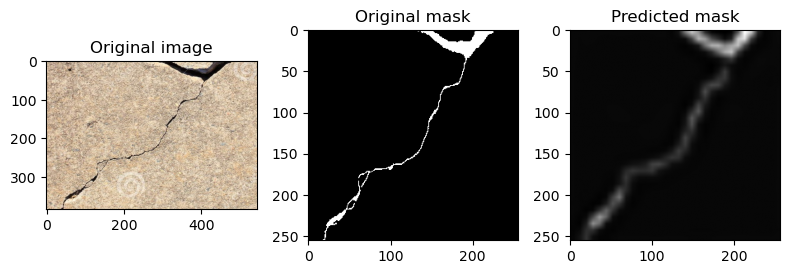

INFO: Early stopping counter 2 of 5
Epoch 9/30


Train loss: 1677.7059.


Valid loss: 1636.4100.
--------------------------------------------------


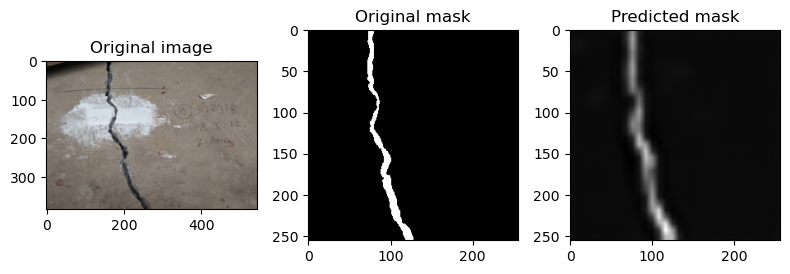

INFO: Early stopping counter 3 of 5
Epoch 10/30


Train loss: 1668.5619.


Valid loss: 1607.9668.
--------------------------------------------------


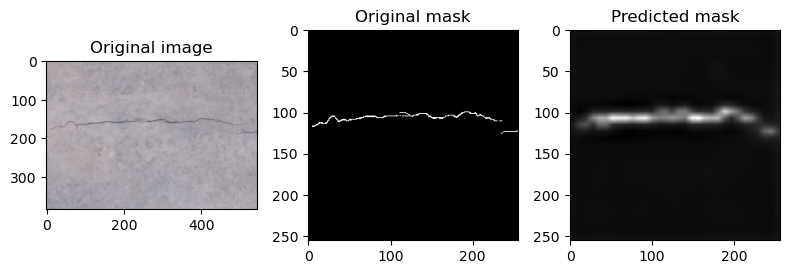

Model saved to: seg_model.pth
Epoch 11/30


Train loss: 1633.7204.


Valid loss: 1549.5358.
--------------------------------------------------


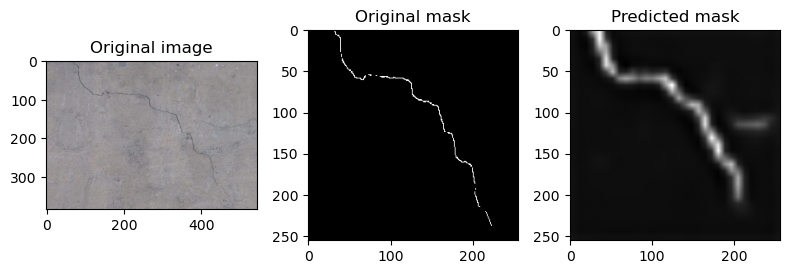

Model saved to: seg_model.pth
Epoch 12/30


Train loss: 1622.0792.


Valid loss: 1601.9642.
--------------------------------------------------


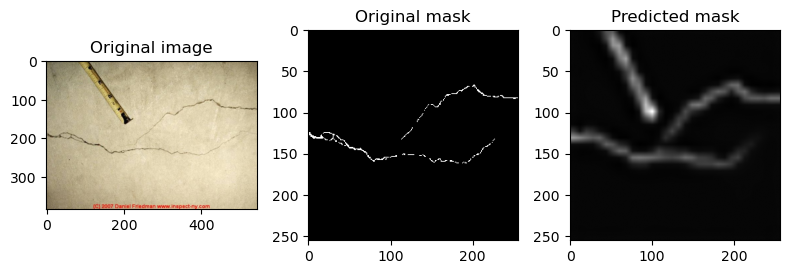

INFO: Early stopping counter 1 of 5
Epoch 13/30


Train loss: 1611.1923.


Valid loss: 1572.5948.
--------------------------------------------------


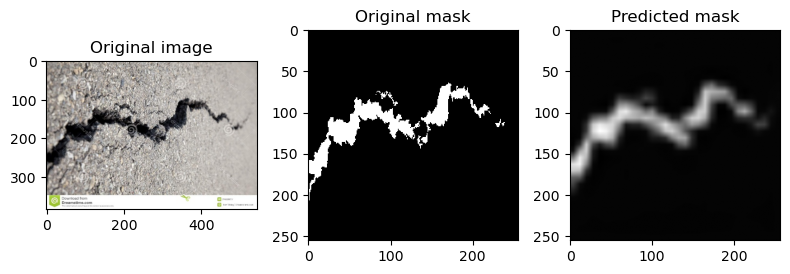

INFO: Early stopping counter 2 of 5
Epoch 14/30


Train loss: 1580.7082.


Valid loss: 1541.3616.
--------------------------------------------------


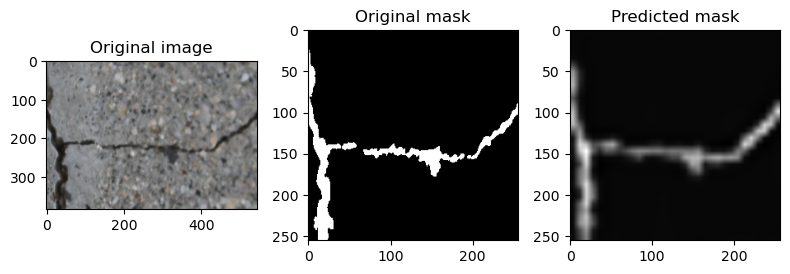

Model saved to: seg_model.pth
Epoch 15/30


Train loss: 1574.5550.


Valid loss: 1556.5059.
--------------------------------------------------


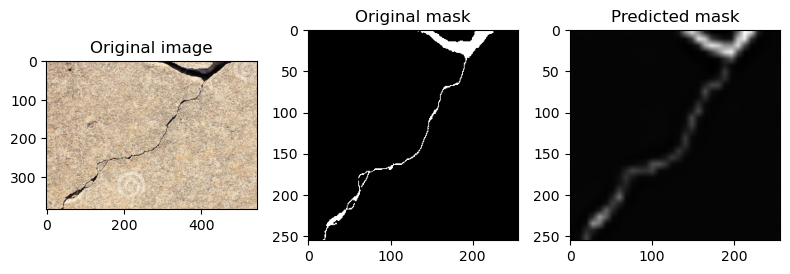

INFO: Early stopping counter 1 of 5
Epoch 16/30


Train loss: 1556.1569.


Valid loss: 1548.0869.
--------------------------------------------------


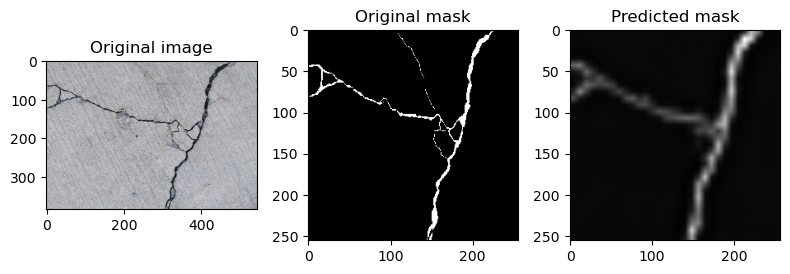

INFO: Early stopping counter 2 of 5
Epoch 17/30


Train loss: 1553.0509.


Valid loss: 1510.0730.
--------------------------------------------------


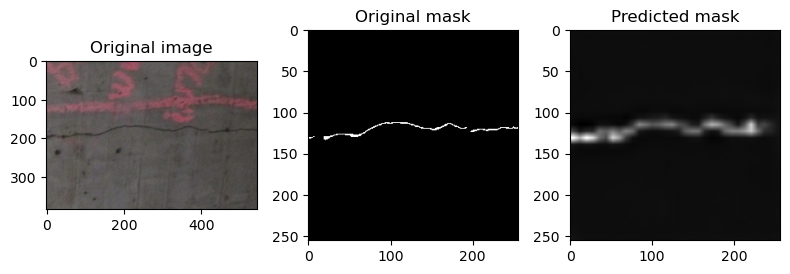

Model saved to: seg_model.pth
Epoch 18/30


Train loss: 1534.8227.


Valid loss: 1510.8441.
--------------------------------------------------


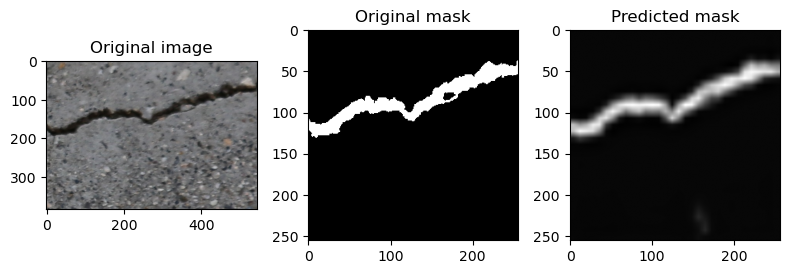

INFO: Early stopping counter 1 of 5
Epoch 19/30


Train loss: 1516.3031.


Valid loss: 1499.2295.
--------------------------------------------------


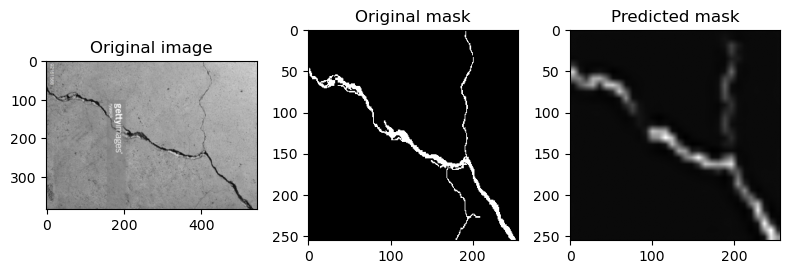

Model saved to: seg_model.pth
Epoch 20/30


Train loss: 1502.2689.


Valid loss: 1498.7468.
--------------------------------------------------


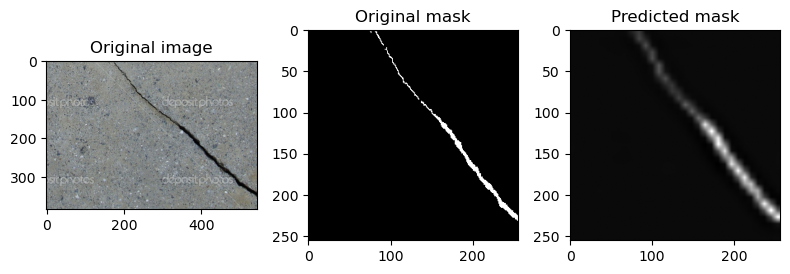

Model saved to: seg_model.pth
Epoch 21/30


Train loss: 1489.1561.


Valid loss: 1461.6798.
--------------------------------------------------


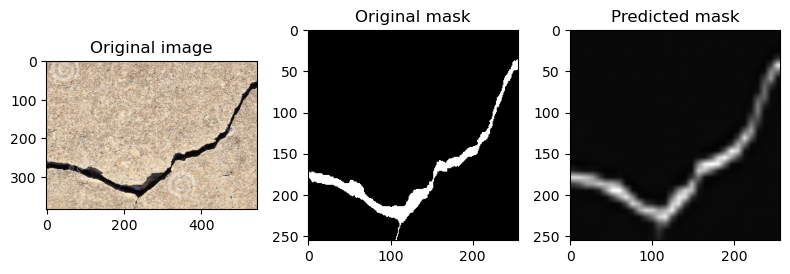

Model saved to: seg_model.pth
Epoch 22/30


Train loss: 1484.0439.


Valid loss: 1493.7609.
--------------------------------------------------


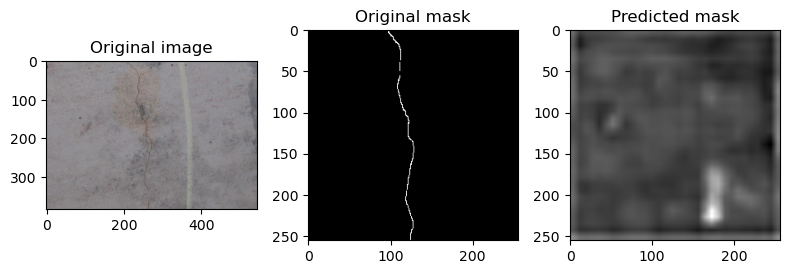

INFO: Early stopping counter 1 of 5
Epoch 23/30


Train loss: 1452.3852.


Valid loss: 1409.7032.
--------------------------------------------------


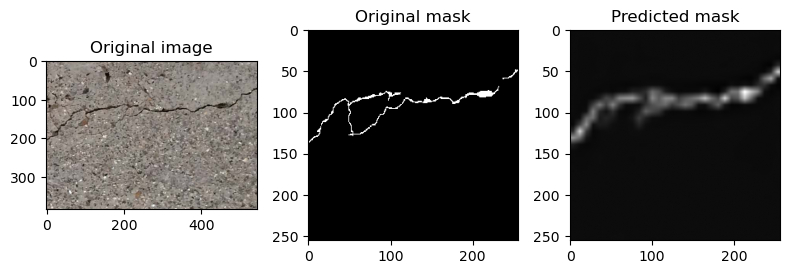

Model saved to: seg_model.pth
Epoch 24/30


Train loss: 1440.9464.


Valid loss: 1447.9397.
--------------------------------------------------


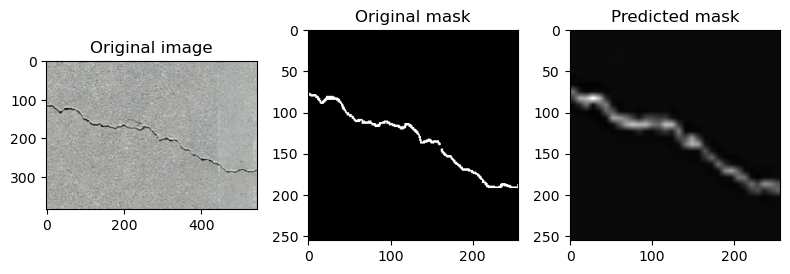

INFO: Early stopping counter 1 of 5
Epoch 25/30


Train loss: 1421.7842.


Valid loss: 1411.6737.
--------------------------------------------------


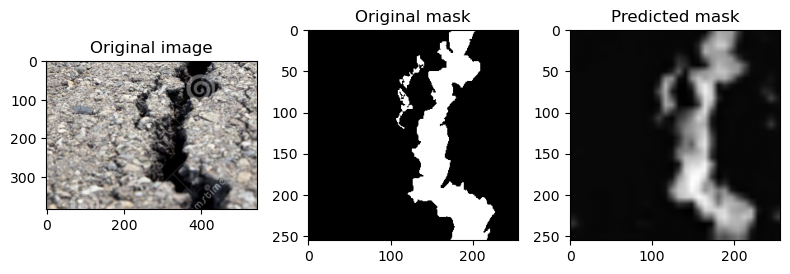

INFO: Early stopping counter 2 of 5
Epoch 26/30


Train loss: 1407.7923.


Valid loss: 1429.8010.
--------------------------------------------------


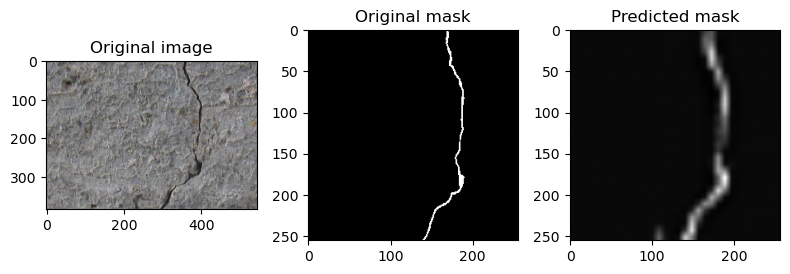

INFO: Early stopping counter 3 of 5
Epoch 27/30


Train loss: 1392.7785.


Valid loss: 1396.8752.
--------------------------------------------------


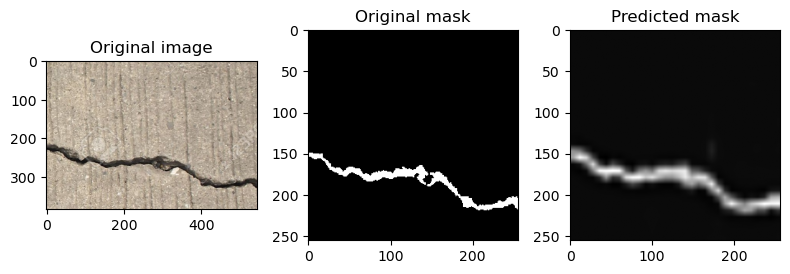

Model saved to: seg_model.pth
Epoch 28/30


Train loss: 1366.3828.


Valid loss: 1385.8359.
--------------------------------------------------


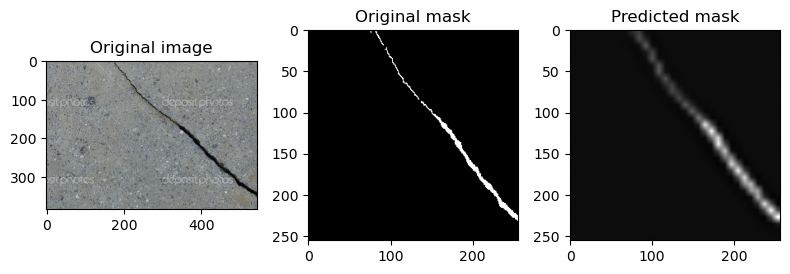

Model saved to: seg_model.pth
Epoch 29/30


Train loss: 1346.7031.


Valid loss: 1379.6121.
--------------------------------------------------


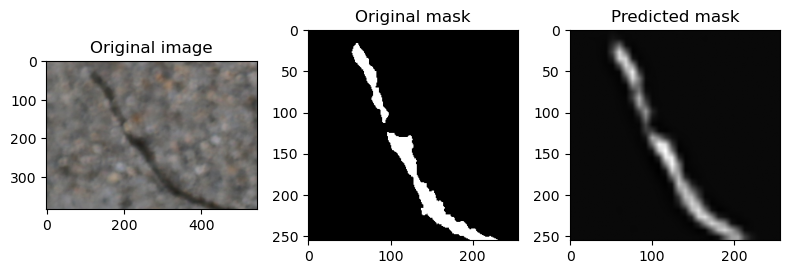

Model saved to: seg_model.pth
Epoch 30/30


Train loss: 1325.5155.


Valid loss: 1364.9214.
--------------------------------------------------


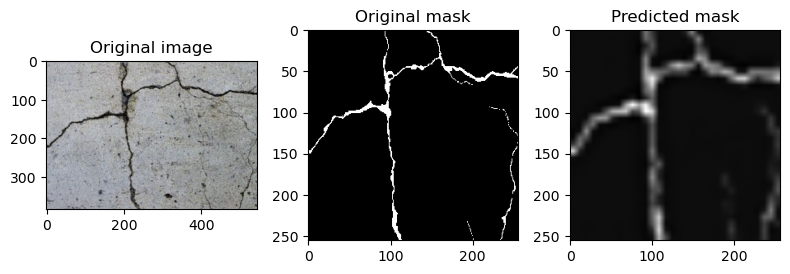

Model saved to: seg_model.pth


In [15]:
train_losses, valid_losses = [], []

for epoch in range(epochs):

    print(f'Epoch {epoch + 1}/{epochs}')
    epoch_train_losses, epoch_valid_losses = [], []
    
    model.train()
    for _, batch in enumerate(tqdm(train_dataloader, leave=False)):
        batch_train_loss = train_one_batch(batch, model, criterion, optimizer)
        epoch_train_losses.append(batch_train_loss)
    epoch_train_loss = np.array(epoch_train_losses).mean()
    train_losses.append(epoch_train_loss)

    print(f'Train loss: {epoch_train_loss:.4f}.')
    
    model.eval()
    for i, batch in enumerate(tqdm(valid_dataloader, leave=False)):
        batch_valid_loss = validate_one_batch(batch, model, criterion)
        epoch_valid_losses.append(batch_valid_loss)
    epoch_valid_loss = np.array(epoch_valid_losses).mean()
    valid_losses.append(epoch_valid_loss)
    print(f'Valid loss: {epoch_valid_loss:.4f}.')
    print('-'*50)    
    
    validate_test_image(model, test)
    
    scheduler.step(epoch_valid_loss)
    early(epoch_valid_loss, model=model)
    if early.early_stop:
        print(f'Validation loss did not improve for {early.patience} epochs. Training stopped.')
        model.load_state_dict(torch.load(path))
        break